# 6. Baseline Model

## 6.1 Import Libraries

In [1]:
import os, random, gc, json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.backend import clear_session
from tensorflow.errors import ResourceExhaustedError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

2024-02-11 06:22:55.667071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 06:22:56.591092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 6.2 Load Sorted Data

In [3]:
def get_image_paths(data_dir):
    image_paths = []
    for root, dirs, files in os.walk(data_dir):
        if set('junk' in root.split(os.sep):
            # Skip 'junk' folder
            continue
        # Iterate 'non-junk' files in folder
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                image_paths.append(os.path.join(root, file))
    return image_paths

image_paths = get_image_paths("../02. Datasets/Images")
df = pd.DataFrame(image_paths, columns=['image_path'])
df['class'] = df['image_path'].apply(lambda x: x.split('/')[-2])

## 6.3 Pre-processing

### 6.3.1 Class Balancing

In [4]:
# Filter out classes with too little samples (min. 2 samples per class is needed for stratify split)
class_counts = df['class'].value_counts()
retain_classes = class_counts[class_counts > 10].index
df = df[df['class'].isin(retain_classes)]
label_encoder = LabelEncoder()
label_encoder.fit(df['class'].unique())
print(f"Classes: {len(label_encoder.classes_)}")

Classes: 71


In [5]:
print(df['class'].value_counts())

class
Dermatitis, Atopic               997
Pityriasis Rosea                 787
Dermatitis, Seborrheic           676
Keratosis, Seborrheic            550
Alopecia Areata                  547
                                ... 
Chloracne                         59
Carbuncle                         58
Necrolytic Migratory Erythema     57
Porokeratosis                     52
Porphyria Cutanea Tarda           52
Name: count, Length: 71, dtype: int64


### 6.3.2 Split into Train(80)/Validation(10)/Test(10) sets

In [6]:
# Split into train & test set
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['class'], random_state=16)

# Further split the train set into train & validation set
train_df, val_df = train_test_split(train_df, test_size=0.1111111111111111, stratify=train_df['class'], random_state=16) # 0.25 x 0.8 = 0.2

In [7]:
def generate_split_report(train_df, val_df, test_df):
    # Calculate counts for each class in each dataset
    train_counts = train_df['class'].value_counts()
    val_counts = val_df['class'].value_counts()
    test_counts = test_df['class'].value_counts()

    # Number of unique classes in each set
    unique_classes_train = len(train_counts)
    unique_classes_val = len(val_counts)
    unique_classes_test = len(test_counts)

    # Print unique classes to confirm if class sizes across sets are equal
    print(f"Classes in Train set: {unique_classes_train}")
    print(f"Classes in Validation set: {unique_classes_val}")
    print(f"Classes in Test set: {unique_classes_test}")
    
    # Create a DataFrame from the counts
    distribution_df = pd.DataFrame({
        'Class': train_counts.index,
        'Train': train_counts.values,
        'Validation': val_counts[train_counts.index].values,
        'Test': test_counts[train_counts.index].values
    })

    return distribution_df

split_report_df = generate_split_report(train_df, val_df, test_df)
split_report_df

Classes in Train set: 71
Classes in Validation set: 71
Classes in Test set: 71


,Class,Train,Validation,Test
0,"Dermatitis, Atopic",797,100,100
1,Pityriasis Rosea,629,79,79
2,"Dermatitis, Seborrheic",540,68,68
3,"Keratosis, Seborrheic",440,55,55
4,Alopecia Areata,437,55,55
...,...,...,...,...
66,Serum Sickness,47,6,6
67,Carbuncle,46,6,6
68,Necrolytic Migratory Erythema,45,6,6
69,Porokeratosis,42,5,5


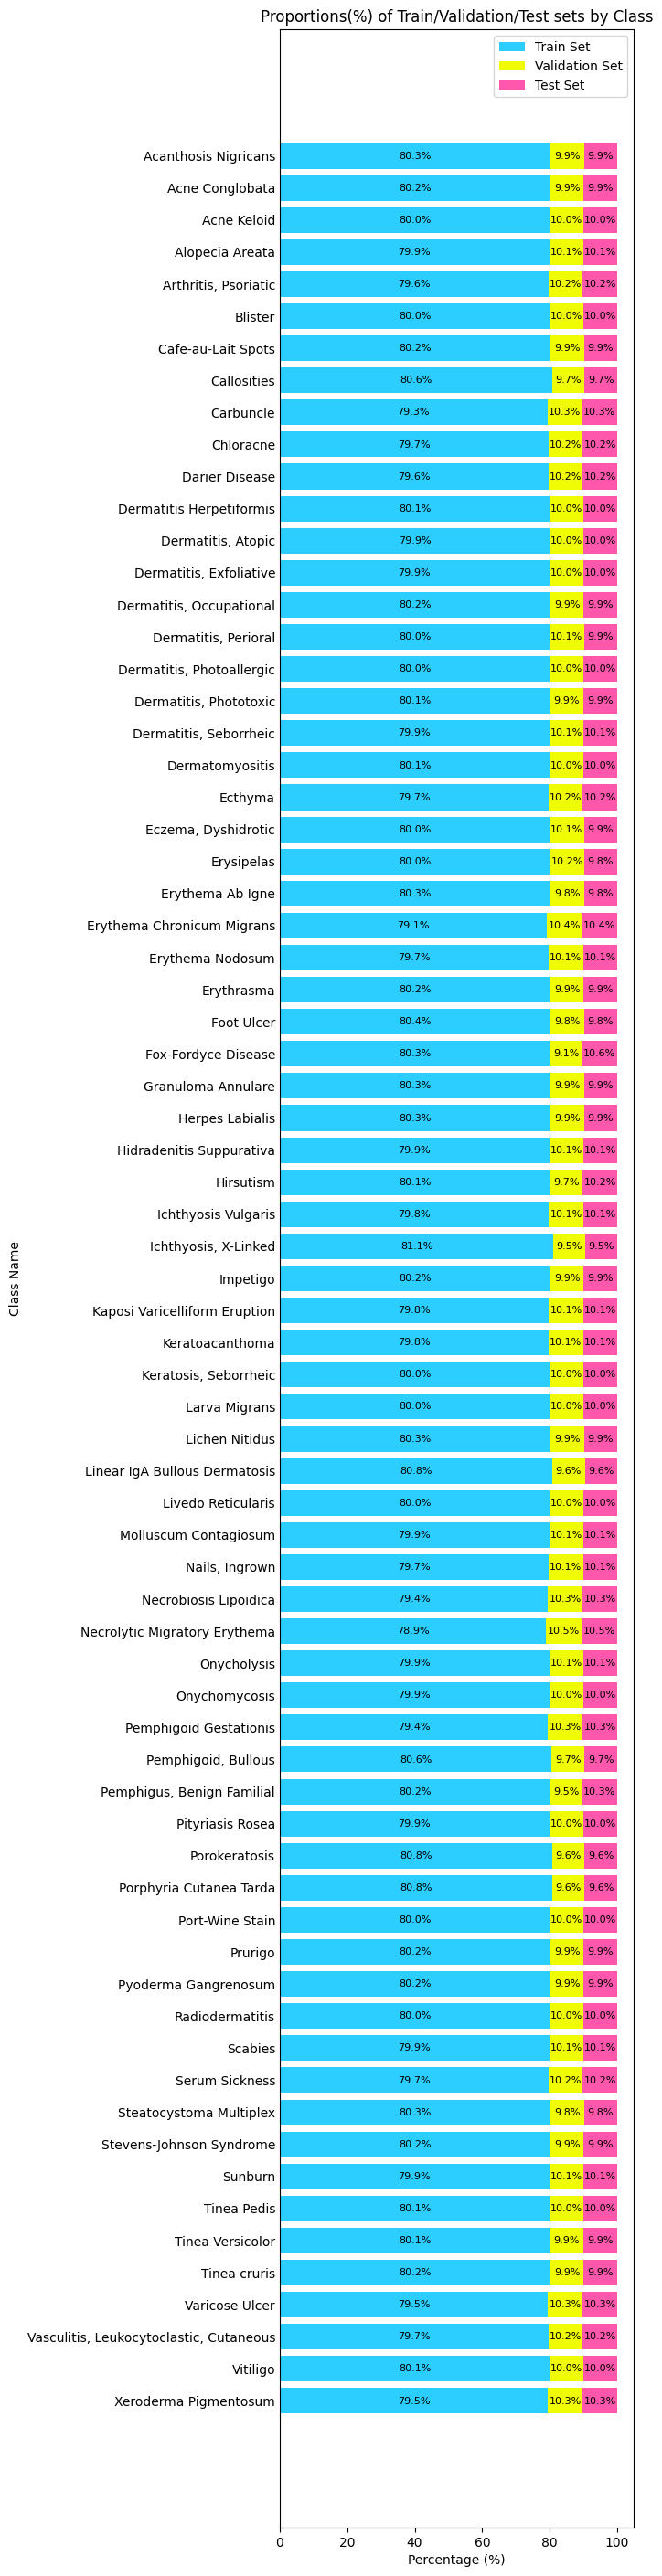

In [8]:
def plot_stacked_bar_chart(df):
    df = df.copy()
    df = df.sort_values('Class', ascending=False)
    df['totalCount'] = df['Train'] + df['Validation'] + df['Test']
    df['trainPercent'] = df['Train'] / df['totalCount'] * 100
    df['validationPercent'] = df['Validation'] / df['totalCount'] * 100
    df['testPercent'] = df['Test'] / df['totalCount'] * 100
    height_per_class = 0.5
    total_classes = len(df['Class'])
    fig_height = height_per_class * total_classes
    fig, ax = plt.subplots(figsize=(5, fig_height))

    # Add labels & title
    ax.set_title('Proportions(%) of Train/Validation/Test sets by Class')
    ax.set_xlabel('Percentage (%)')
    ax.set_ylabel('Class Name')
    ax.tick_params(axis='y', length=0)
    bars_train = ax.barh(df['Class'], df['trainPercent'], color='#2bceff', label='Train Set')
    bars_validation = ax.barh(df['Class'], df['validationPercent'], color='#f0fc03', left=df['trainPercent'], label='Validation Set')
    bars_test = ax.barh(df['Class'], df['testPercent'], color='#ff57ab', left=df['trainPercent'] + df['validationPercent'], label='Test Set')

    # Annotate bars with (%) values
    for bars in [bars_train, bars_validation, bars_test]:
        for bar in bars:
            if bar.get_width() > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                        f"{bar.get_width():.1f}%", va='center', ha='center', color='black', fontsize=8)
    ax.legend()
    plt.show()

plot_stacked_bar_chart(split_report_df)

### 6.3.3 Data Generators for Augmentation & Preprocessing 

To setup a generator for pre-processing & augmenting (as required) image data. Goal is to normalize/format/augment the images to improve the model's ability to learn varied representative data

In [8]:
def custom_image_preprocessor(img_array):
    # Convert mode of NumPy array images to PIL image
    img = Image.fromarray((img_array * 255).astype('uint8'), 'RGB')
    
    # --- Pre-processing steps ---
    # BLANK
    
    # --- Convert back to NumPy array --- 
    img_array = np.array(img) / 255.0 
    return img_array
    
# Create an ImageDataGenerator for raw data Pre-processing
imageDataGenerator = ImageDataGenerator(
    # --- Pre-processing ---
    # preprocessing_function=custom_image_preprocessor,
    rescale=1./255,        # normalize (re-scale) pixel values to [0,1] range, by dividing by 255
    fill_mode='constant',  # deal with resizing issues(aspect ratio don't match target size) by filling areas outside the image boundaries with a constant pixel color
    cval=0,                # constant fill color to use if fill_mode is 'constant'. 0 to fill with black pixels
    # --- Augmentations ---
)

## 6.4 Deep Learning

### 6.4.1 Design Baseline Architecture: Feedforward Neural Network(FNN)

#### 6.4.1.1 Overview

<u>Architecture Overview</u>

**Input Layer**
- add a Flatten layer to convert 2D images into a 1D array

**Hidden Layer 1**
- add 1st Dense layer (128 Neurons, ReLU Activation) to learn patterns from the flattened input data

**Dropout Layer 1**
- add 1st Regularization layer (50% Dropout Rate) to randomly select a subset of neurons to ignore during training

**Hidden Layer 2**
- add 2nd Dense layer (64 Neurons, ReLU Activation) to further process patterns learned by previous layers

**Output Layer**
- add Final Dense layer (Neurons = Number of Classes, Softmax Activation) for multi-class classification. This layer outputs a probability distribution over the classes

#### 6.4.1.2 Architecture Design & Neural Network Configuration

In [9]:
# --- Classes --- 
NUM_CLASSES = len(label_encoder.classes_)  # total number of unique classes to predict
# set class weights for unabalanced classes
CLASS_WEIGHTS = compute_class_weight('balanced', classes=np.unique(train_df['class']), y=train_df['class'])
CLASS_WEIGHTS = dict(enumerate(CLASS_WEIGHTS))

# --- Pre-processing Parameters-Images --- 
TARGET_IMG_WIDTH = 256          # image width
TARGET_IMG_HEIGHT = 256         # image height
TARGET_IMG_COLOR_CHANNELS = 3   # number of color channels (3 for RGB channels)
TARGET_BATCH_SIZE = 32          # number of images to process in a single batch, during training
INPUT_SHAPE = (TARGET_IMG_WIDTH, TARGET_IMG_HEIGHT, TARGET_IMG_COLOR_CHANNELS)

# --- Baseline FNN Architecture ---
DENSE_LAYER_NEURONS = [16, 32, 64, 64]     # index represents total neurons to use for the corresponding dense layer
ACTIVATION = 'relu'                        # introduce non-linearity in the model
LAST_LAYER_ACTIVATION = 'softmax'          # for multi-class single-label problems. convert logits to probabilities by normalizing output to a probability distribution over output classes

# --- Training Configurations ---
EPOCHS = 50                                # number of complete passes to run on the train set
LOSS_FUNCTION = 'categorical_crossentropy' # for multi-class single-label problems
HYPERPARAMETERS = {
    "LEARNING_RATE": [0.1, 0.01],              # Learning rate of optimizer - step-size used for each iteration in moving toward a loss function minimum
    "DROPOUT_RATE": [0.1, 0.3, 0.5],           # % of neurons outputs to randomly ignore, to reduce overfitting
    # Regularization - penalize large weights, to reduce over-fitting
    "L1_REGULARIZATION": [0.01, 0.001],        # Lasso - add absolute weight values as penalty to loss function, to help feature selection
    "L2_REGULARIZATION": [0.01, 0.001],        # Ridge - add square of weights magnitude as penalty to loss function. to help reduce model complexity
    "OPTIMIZERS": ['adam', 'sgd', 'rmsprop']
}

# --- Callbacks ---
class CallbacksManager:
    def get_callbacks(self):
        # Schedule learning rate - to dynamically adjust learning rate based on rate of change in validation loss during training
        LR_SCHEDULER = ReduceLROnPlateau(
            monitor='val_loss',   # reduce learning rate when validation loss metric stopped improving
            factor=0.1, 
            patience=5,
            min_lr=0.00001, 
            verbose=1
        )
        
        # Stop training early, to reduce over-fitting
        EARLY_STOP = EarlyStopping(
            monitor='val_loss',
            patience=10
        )
        
        return [LR_SCHEDULER, EARLY_STOP]
CALLBACKSmanager = CallbacksManager()

# --- Optimizer ---  to optimize adaptive learning rate
class OptimizerManager:
    def get_optimizer(self, optimizer_name, learning_rate):
        if optimizer_name == 'adam':
            return Adam(learning_rate=learning_rate)    # general choice - suit most cases
        elif optimizer_name == 'sgd':
            return SGD(learning_rate=learning_rate)     # classic choice - suit simple models with small datasets
        elif optimizer_name == 'rmsprop':
            return RMSprop(learning_rate=learning_rate) # adaptive choice - suit problems with noisy or non-stationary data
        else:
            raise ValueError("No such optimizer")
            
OPTIMIZERMANAGER = OptimizerManager()

# --- Performance Evaluation Metrics ---
EVALUATION_METRICS = ['accuracy', Precision(), Recall()]

2024-02-11 06:23:45.534661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 06:23:45.655850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 06:23:45.655910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 06:23:45.657736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-11 06:23:45.657808: I tensorflow/compile

### 6.4.2 Data Generators for Training/Validation/Testing

To ensure input data being fed to the model during train/validation/test phases is consistent/efficient across all 3 phases, the previously configured ImageDataGenerator is utilized to handle loading/pre-processing/batching of input images and their corresponding labels

In [10]:
# Create generator for training data
TRAIN_DAT_GENERATOR = imageDataGenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',                                 # df column of 'image paths'
    y_col='class',                                      # df column of 'class labels'
    target_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),  # re-size image to specific size
    batch_size=TARGET_BATCH_SIZE,                       # total images to yield from the generator, per batch
    class_mode='categorical',                           # one-hot encode all class labels
    drop_remainder=True                                 # ensure all batches have the same shape by dropping last batch in each epoch if number of samples is not divisible by batch size
)

# Create generator for validation data
VAL_DAT_GENERATOR = imageDataGenerator.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='class',
    target_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),
    batch_size=TARGET_BATCH_SIZE,
    class_mode='categorical',
    drop_remainder=True
)

# Create generator for test data
TEST_DAT_GENERATOR = imageDataGenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='class',
    target_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),
    batch_size=TARGET_BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    drop_remainder=True
)

Found 14351 validated image filenames belonging to 71 classes.
Found 1794 validated image filenames belonging to 71 classes.
Found 1794 validated image filenames belonging to 71 classes.


### 6.4.3 Model Compilation

In [11]:
class NeuralNetwork:
    def __init__(self, input_shape, num_classes):
        self.model = Sequential()
        self.input_shape = input_shape
        self.num_classes = num_classes

    def add_layers(self, dense_layer_neurons, dropout_rate, activation, l1_reg, l2_reg):
        self.model.add(Flatten(input_shape=self.input_shape))
        for neurons in dense_layer_neurons:
            self.model.add(Dense(neurons, activation=activation,
                                 kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
            self.model.add(Dropout(dropout_rate))
        self.model.add(Dense(self.num_classes, activation='softmax'))
    
    def compile_model(self, optimizer, loss_function, metrics):
        self.model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    def train(self, train_generator, val_generator, epochs, callbacks):
        self.history = self.model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs,
            callbacks=callbacks,
            class_weight=CLASS_WEIGHTS,
            verbose=1
        )
        
    def evaluate(self, test_data):
        test_results = self.model.evaluate(test_data)
        if len(test_results) >= 4:
            precision = test_results[2]
            recall = test_results[3]
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
            test_results.append(f1_score)
        return test_results
    
    def get_history(self):
        return self.history
    
    def summary(self):
        return self.model.summary()

    def generate_predictions(self, data_generator):
        data_generator.reset()
        steps = len(data_generator)
        preds = self.model.predict(data_generator, steps=steps)
        predictions = np.argmax(preds, axis=1)
        true_labels = data_generator.classes
        return predictions, true_labels

    def generate_classification_report(self, data_generator, label_encoder):
        predictions, true_labels = self.generate_predictions(data_generator)
        report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)
        print(f"Classification Report:\n{report}")
        test_accuracy = accuracy_score(true_labels, predictions)
        print(f"Accuracy: {test_accuracy:.4f}")

    def generate_confusion_matrix(self, data_generator, label_encoder):
        predictions, true_labels = self.generate_predictions(data_generator)
        cm = confusion_matrix(true_labels, predictions, labels=np.arange(self.num_classes))
        cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        fig, ax = plt.subplots(figsize=(6, 5))
        cmp.plot(ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.show()

### 6.4.4 Hyperparameter Tuning

In [12]:
baseline_hyperparam_tuning_train_histories = {}
loop_counter = 0

# Try different LEARNING RATES
for lr_index in range(len(HYPERPARAMETERS['LEARNING_RATE'])):
    # Try different DROPOUT RATES
    for dropout_index in range(len(HYPERPARAMETERS['DROPOUT_RATE'])):
        # Try different L1_REGULARIZATION values
        for l1_index in range(len(HYPERPARAMETERS['L1_REGULARIZATION'])):
            # Try different L2_REGULARIZATION values
            for l2_index in range(len(HYPERPARAMETERS['L2_REGULARIZATION'])):
                # Try different OPTIMIZERS
                for optimizer_index in range(len(HYPERPARAMETERS['OPTIMIZERS'])):
                    # Extract current combination of hyperparameters
                    lr = HYPERPARAMETERS['LEARNING_RATE'][lr_index]
                    dropout_rate = HYPERPARAMETERS['DROPOUT_RATE'][dropout_index]
                    l1_reg = HYPERPARAMETERS['L1_REGULARIZATION'][l1_index]
                    l2_reg = HYPERPARAMETERS['L2_REGULARIZATION'][l2_index]
                    optimizer_name = HYPERPARAMETERS['OPTIMIZERS'][optimizer_index]

                    # --- Start Training ---
                    FNN = NeuralNetwork(INPUT_SHAPE, NUM_CLASSES)
                    FNN.add_layers(DENSE_LAYER_NEURONS, dropout_rate, ACTIVATION, l1_reg, l2_reg)
                    FNN.compile_model(OPTIMIZERMANAGER.get_optimizer(optimizer_name, lr), LOSS_FUNCTION, EVALUATION_METRICS)
                    try:
                        FNN.train(TRAIN_DAT_GENERATOR, VAL_DAT_GENERATOR, EPOCHS, CALLBACKSmanager.get_callbacks())
                    except ResourceExhaustedError:
                        print(f"OOM error with configuration: LR={lr}, Dropout={dropout_rate}, L1={l1_reg}, L2={l2_reg}, Optimizer={optimizer_name}")
                        break
                    key = {
                        'LEARNING_RATE': lr_index,
                        'DROPOUT_RATE': dropout_index,
                        'L1_REGULARIZATION': l1_index,
                        'L2_REGULARIZATION': l2_index,
                        'OPTIMIZERS': optimizer_index,
                        'history': FNN.get_history().history
                    }
                    baseline_hyperparam_tuning_train_histories[loop_counter] = key
                    loop_counter += 1
                    # Delete model instance & clear session
                    del FNN
                    gc.collect()
                    clear_session()

Epoch 1/10


2024-02-10 14:36:30.330551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-10 14:36:30.402562: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0390051e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-10 14:36:30.402597: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-10 14:36:30.419400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-10 14:36:30.457777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-02-10 14:36:30.628072: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

449/449 [==============================] - 65s 139ms/step - loss: 2790.7759 - accuracy: 0.0067 - precision: 0.0141 - recall: 3.4841e-04 - val_loss: 245.0496 - val_accuracy: 0.0268 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.1000
Epoch 2/10
449/449 [==============================] - 57s 126ms/step - loss: 8781.9199 - accuracy: 0.0059 - precision: 0.0122 - recall: 6.9682e-05 - val_loss: 6422.4536 - val_accuracy: 0.0028 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.1000
Epoch 3/10
449/449 [==============================] - 57s 126ms/step - loss: 844.3068 - accuracy: 0.0056 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 182.2481 - val_accuracy: 0.0178 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.1000
Epoch 4/10
449/449 [==============================] - 57s 126ms/step - loss: 187.8145 - accuracy: 0.0059 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 193.5854 - val_accuracy: 0.0033 - val_precision: 0.0000e+00 - val_recall: 

In [14]:
baseline_hyperparam_tuning_train_histories

{0: {'LEARNING_RATE': 0,
  'DROPOUT_RATE': 0,
  'L1_REGULARIZATION': 0,
  'L2_REGULARIZATION': 0,
  'OPTIMIZERS': 0,
  'history': {'loss': [22224.11328125,
    9696.4345703125,
    10594.7431640625,
    12107.8486328125,
    8532.47265625],
   'accuracy': [0.20123839378356934,
    0.18575851619243622,
    0.18575851619243622,
    0.23839008808135986,
    0.16099071502685547],
   'precision': [0.20370370149612427,
    0.3333333432674408,
    0.2142857164144516,
    0.38461539149284363,
    0.0],
   'recall': [0.06811145693063736,
    0.009287925437092781,
    0.009287925437092781,
    0.015479875728487968,
    0.0],
   'val_loss': [12820.4150390625,
    4528.900390625,
    7069.37060546875,
    7590.72412109375,
    10547.4775390625],
   'val_accuracy': [0.19512194395065308,
    0.17073170840740204,
    0.2195121943950653,
    0.19512194395065308,
    0.17073170840740204],
   'val_precision': [0.0, 0.0, 0.0, 0.0, 0.0],
   'val_recall': [0.0, 0.0, 0.0, 0.0, 0.0],
   'lr': [0.1, 0.1, 0.1,

Export grid search results to static .json file

In [13]:
def convert(o):
    if isinstance(o, np.float32):
        return float(o)
    raise TypeError

try:
    with open('../03. Outputs/baseline_hyperparam_tuning_train_histories.json', 'w') as file:
        json.dump(baseline_hyperparam_tuning_train_histories, file, default=convert)
    print("Export successful. File saved as 'baseline_hyperparam_tuning_train_histories.json'")
except Exception as e:
    print("An error occurred:", e)

Export successful. File saved as 'baseline_hyperparam_tuning_train_histories.json'


Import grid search results from static .json file

In [13]:
import json

try:
    with open('../03. Outputs/baseline_hyperparam_tuning_train_histories.json', 'r') as file:
        baseline_hyperparam_tuning_train_histories = json.load(file)
    print("Import successful.")
except Exception as e:
    print("An error occurred:", e)


Import successful.


In [14]:
def find_best_hyperparameters(train_histories, hyperparameter_dict, metric='loss'):
    best_metric_value = float('inf') if metric in ['loss', 'val_loss'] else 0
    best_config = None
    for key, history in train_histories.items():
        metric_values = history['history'].get(metric)
        if metric_values:
            avg_metric_value = sum(metric_values) / len(metric_values)
            if (metric in ['loss', 'val_loss'] and avg_metric_value < best_metric_value) or \
               (metric not in ['loss', 'val_loss'] and avg_metric_value > best_metric_value):
                best_metric_value = avg_metric_value
                best_config = key
    if best_config is not None:
        mapped_best_config = {param: hyperparameter_dict[param][train_histories[best_config][param]] 
                              for param in hyperparameter_dict}
        mapped_best_config['history'] = train_histories[best_config]['history']
        return mapped_best_config, best_metric_value
    else:
        return None, None

def print_hyperparameters_report(hyperparameters, metric_value, metric):
    print(f"\nBest Hyperparameters for {metric.capitalize()}:")
    for key, value in hyperparameters.items():
        if key != 'history':
            print(f"  {key}: {value}")
    print(f"Best {metric.capitalize()} Value: {metric_value}")

metrics = ['accuracy', 'precision', 'loss', 'recall', 'val_loss', 'val_precision', 'val_recall', 'val_accuracy']
for metric in metrics:
    best_config, best_metric_value = find_best_hyperparameters(baseline_hyperparam_tuning_train_histories, HYPERPARAMETERS, metric=metric)
    if best_config is not None:
        print_hyperparameters_report(best_config, best_metric_value, metric)
    else:
        print(f"No best configuration found for {metric}.")


Best Hyperparameters for Accuracy:
  LEARNING_RATE: 0.01
  DROPOUT_RATE: 0.1
  L1_REGULARIZATION: 0.01
  L2_REGULARIZATION: 0.01
  OPTIMIZERS: rmsprop
Best Accuracy Value: 0.016904745250940323

Best Hyperparameters for Precision:
  LEARNING_RATE: 0.1
  DROPOUT_RATE: 0.5
  L1_REGULARIZATION: 0.001
  L2_REGULARIZATION: 0.001
  OPTIMIZERS: adam
Best Precision Value: 0.055202723923139276

Best Hyperparameters for Loss:
  LEARNING_RATE: 0.1
  DROPOUT_RATE: 0.1
  L1_REGULARIZATION: 0.001
  L2_REGULARIZATION: 0.001
  OPTIMIZERS: sgd
Best Loss Value: 4.635037660598755

Best Hyperparameters for Recall:
  LEARNING_RATE: 0.1
  DROPOUT_RATE: 0.1
  L1_REGULARIZATION: 0.01
  L2_REGULARIZATION: 0.01
  OPTIMIZERS: rmsprop
Best Recall Value: 0.002221291302703321

Best Hyperparameters for Val_loss:
  LEARNING_RATE: 0.1
  DROPOUT_RATE: 0.3
  L1_REGULARIZATION: 0.001
  L2_REGULARIZATION: 0.01
  OPTIMIZERS: sgd
Best Val_loss Value: 4.464636039733887

Best Hyperparameters for Val_precision:
  LEARNING_RATE

### 6.4.5 Train & Evaluate Performance

#### 6.4.5.1 Train optimized Model

In [12]:
# --- Compile Model ---
BEST_LEARNING_RATE= 0.1
BEST_DROPOUT_RATE= 0.1
BEST_L1_REGULARIZATION= 0.001
BEST_L2_REGULARIZATION= 0.01
BEST_OPTIMIZER= 'rmsprop'
FNN = NeuralNetwork(INPUT_SHAPE, NUM_CLASSES)
FNN.add_layers(DENSE_LAYER_NEURONS, BEST_DROPOUT_RATE, ACTIVATION, BEST_L1_REGULARIZATION, BEST_L2_REGULARIZATION)
FNN.compile_model(OPTIMIZERMANAGER.get_optimizer(BEST_OPTIMIZER, BEST_LEARNING_RATE), LOSS_FUNCTION, EVALUATION_METRICS)
FNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 16)                3145744   
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [13]:
# --- Start Training ---
try:
    FNN.train(TRAIN_DAT_GENERATOR, VAL_DAT_GENERATOR, EPOCHS, CALLBACKSmanager.get_callbacks())
except ResourceExhaustedError:
    print(f"OOM error")

Epoch 1/50


2024-02-11 06:24:37.259443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-11 06:24:37.336603: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fe4fc046d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-11 06:24:37.336706: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-11 06:24:37.353396: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-11 06:24:37.395185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-02-11 06:24:37.543859: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

449/449 [==============================] - 64s 139ms/step - loss: 5302.2207 - accuracy: 0.0126 - precision: 0.0245 - recall: 0.0017 - val_loss: 857.6888 - val_accuracy: 0.0195 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.1000
Epoch 2/50
449/449 [==============================] - 58s 129ms/step - loss: 1768.4814 - accuracy: 0.0112 - precision: 0.0243 - recall: 0.0012 - val_loss: 304.1409 - val_accuracy: 0.0111 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.1000
Epoch 3/50
449/449 [==============================] - 58s 129ms/step - loss: 1787.6970 - accuracy: 0.0104 - precision: 0.0237 - recall: 0.0013 - val_loss: 134.0815 - val_accuracy: 0.0117 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.1000
Epoch 4/50
449/449 [==============================] - 57s 127ms/step - loss: 1517.6135 - accuracy: 0.0145 - precision: 0.0344 - recall: 0.0025 - val_loss: 340.6436 - val_accuracy: 0.0061 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.1000

#### 6.4.5.2 Validation Strategy

The project uses `Holdout Validation` & `Early Stopping` approach to validate model performance

**`K-Fold Cross-Validation`**

Although K-fold cross-validation is very thorough in evaluating models, it will not be used in this project due to resource limitations. It is impractical/infeasible to train the model multiple times(once per fold) on the dataset acquired in this project due to it's large size(estimated at 1~2GB). There is insufficient funds for cloud computing resources(google colab subscription) and insufficient project time(need to meet project deadline) to perform k-fold evaluation on each iterated model architecture. Also, k-fold is not compulsory for getting a reasonable evaluation on the dataset

**`Holdout Validation`**

To address limitations in computational resources & project time, holdout validation will be used to assess model performance. A portion of the training data will be set aside for both validation(validation set) & testing(test set) during dataset splitting. This approach avoids the need to conduct repetitive training cycles and can be used to evaluate model performance in a straightforward efficient manner using separate non-overlapping sets for training/validation/testing. Standard classification evaluation metrics can be used to determine how well the model make predictions on new data and gauge it's ability to generalize to unseen data using this approach

**`Early Stopping`**

To prevent over-training, early stopping will be used as a safeguard to to speed up training times by terminating the training process when there is no signs of further improvements in model performance on the validation set over a specified number of epochs. Early stopping ensures the model does not learn patterns that don't generalize well to unseen data, which helps prevent over-fitting as well. By continuously monitoring the model's performance on the validation set(specifically looking at validation loss metrics), it will allow training to be stopped earlier at the right time without compromising model performance 

#### 6.4.5.3 Training & Validation Loss

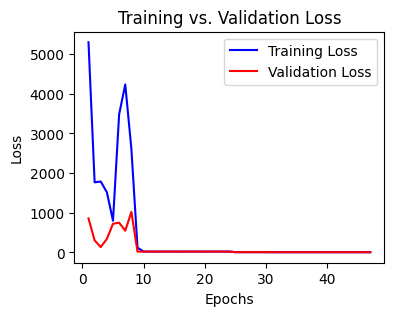

In [16]:
training_loss = FNN.get_history().history['loss']
validation_loss = FNN.get_history().history['val_loss']
epochs = range(1, len(training_loss) + 1)
plt.figure(figsize=(4, 3))
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 6.4.5.4 Analyse Overall Performance Metrics

<u>Quick glance at overall performance metrics aggregated across all classes</u>

- Create a plot to analyse metrics side-by-side to see how well the model is minimizing error(loss), alongside it's classification performance. This gives insights into the model’s balance between it's learning efficiency(loss minimization) <-> decision-making accuracy(precision/recall) and help identify if improvements in loss yields better corresponding precision/recall, indicating if the model is well-balanced or not

- This will also reveal issues with code implementation that require manual correction(eg. abnormal trends in the metrics)

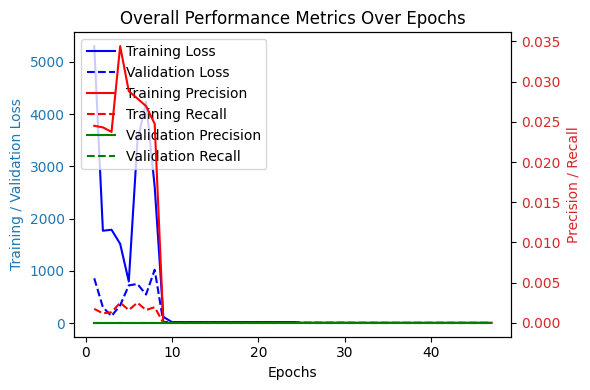

In [23]:
training_precision = FNN.get_history().history['precision']
training_recall = FNN.get_history().history['recall']
validation_precision = FNN.get_history().history['val_precision']
validation_recall = FNN.get_history().history['val_recall']
fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training / Validation Loss', color='tab:blue')
ln1 = ax1.plot(epochs, training_loss, 'b-', label='Training Loss')
ln2 = ax1.plot(epochs, validation_loss, 'b--', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()  
ax2.set_ylabel('Precision / Recall', color='tab:red')
ln3 = ax2.plot(epochs, training_precision, 'r-', label='Training Precision')
ln4 = ax2.plot(epochs, training_recall, 'r--', label='Training Recall')
ln5 = ax2.plot(epochs, validation_precision, 'g-', label='Validation Precision')
ln6 = ax2.plot(epochs, validation_recall, 'g--', label='Validation Recall')
ax2.tick_params(axis='y', labelcolor='tab:red')
lns = ln1 + ln2 + ln3 + ln4 + ln5 + ln6
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper left')
plt.title('Overall Performance Metrics Over Epochs')
fig.tight_layout()
plt.show()

#### 6.4.5.5 Final Evaluation on Test Set

Understand how well the model is performing for each individual class

In [24]:
# Display detailed classification report
FNN.generate_classification_report(TEST_DAT_GENERATOR, label_encoder)

57/57 [==============================] - 7s 122ms/step
Classification Report:
                                         precision    recall  f1-score   support

                   Acanthosis Nigricans       0.00      0.00      0.00        21
                        Acne Conglobata       0.00      0.00      0.00        38
                            Acne Keloid       0.00      0.00      0.00        42
                        Alopecia Areata       0.00      0.00      0.00        55
                   Arthritis, Psoriatic       0.00      0.00      0.00        17
                                Blister       0.00      0.00      0.00        42
                     Cafe-au-Lait Spots       0.02      1.00      0.04        33
                            Callosities       0.00      0.00      0.00         6
                              Carbuncle       0.00      0.00      0.00         6
                              Chloracne       0.00      0.00      0.00         6
                         Darie

/home/monke/FP Code/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/monke/FP Code/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/monke/FP Code/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Show distribution of predictions across different classes and highlight areas where the model confuse itself over one class for another

57/57 [==============================] - 6s 108ms/step


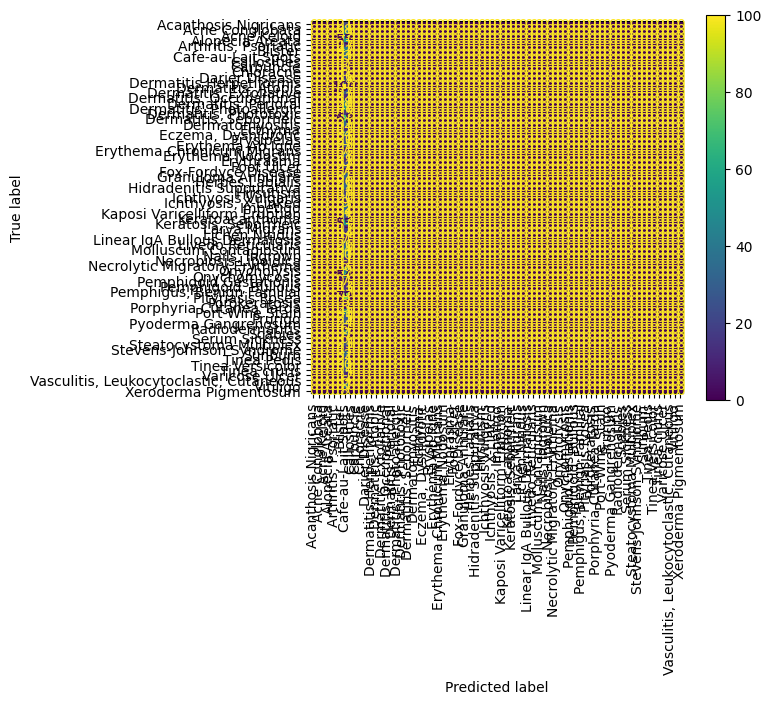

In [25]:
# Display confusion matrix
FNN.generate_confusion_matrix(TEST_DAT_GENERATOR, label_encoder)

#### 6.4.5.6 Export all train/validation/test histories to a static .JSON file

In [26]:
TEST_DAT_GENERATOR.reset()
test_history = FNN.evaluate(TEST_DAT_GENERATOR)
baseline_model_histories = {
    "train_val_history": FNN.get_history().history,
    "test_history": test_history
}

def convert(o):
    if isinstance(o, np.float32):
        return float(o)
    raise TypeError

try:
    with open('../03. Outputs/baseline_model_histories.json', 'w') as file:
        json.dump(baseline_model_histories, file, default=convert)
    print("Export is successful. File saved as 'baseline_model_histories.json'")
except Exception as e:
    print("An error occurred:", e)

57/57 [==============================] - 6s 110ms/step - loss: 4.2366 - accuracy: 0.0184 - precision: 0.0000e+00 - recall: 0.0000e+00
Export is successful. File saved as 'baseline_model_histories.json'


#### 6.4.5.7 Export trained baseline model as .tf files

In [32]:
FNN.model.save('../04. Trained_Models/Baseline_Model.tf')

INFO:tensorflow:Assets written to: ../04. Trained_Models/Baseline_Model.tf/assets


INFO:tensorflow:Assets written to: ../04. Trained_Models/Baseline_Model.tf/assets
